# Throughput

We can calculate the requests per second for the days of data we have. We could parse the WARC data to look at the request records. But for efficiency we can use the CDX index file and assume that every response has a corresponding request.

In [19]:
import glob

cdx_files = glob.glob('warcs/liveweb-*/*cdx.gz')
len(cdx_files)

2056

We are going to need Spark to sort, since the CDX isn't ordered by time but by URL.

In [1]:
import sys

sys.path.append('../utils')
from warc_spark import init

sc, sqlc = init()

Here's a somewhat convoluted function that reads a set of cdx_files, opens them and returns an iterator for all the timestamps in the CDX files. We will use this function with Spark in a second.

In [9]:
import io
import gzip

def get_times(cdx_files):
    for cdx_file in cdx_files:
        with gzip.open(cdx_file, 'rb') as gz:
            fh = io.BufferedReader(gz)
            first = True
            for line in fh.readlines():
                # skip the first line in each file (header)
                if first:
                    first = False
                    continue
                parts = line.decode().split(" ")
                yield (parts[1], 1)

Use Spark to read all the cdx files for 2018. 

In [67]:
cdx = sc.parallelize(cdx_files)
times = cdx.mapPartitions(get_times)
times.take(5)

[('20161025002536', 1),
 ('20161025011918', 1),
 ('20161025011947', 1),
 ('20161024232642', 1),
 ('20161024232648', 1)]

Group the results by seconds and count the number of requests in that second.

In [75]:
combined_times = times.combineByKey(
    lambda r: 1,
    lambda a, b: a + b,
    lambda a, b: a + b
)

combined_times.take(25)
df = combined_times.toDF(['time', 'count'])
df.write.csv('results/times', compression="gzip", header=True)

In [2]:
spark_df = sqlc.read.csv('results/times', header=True, inferSchema=True)
spark_df = spark_df.sort(spark_df['count'].desc())

In [3]:
spark_df.show(10)

+--------------+-----+
|          time|count|
+--------------+-----+
|20141025215248|  814|
|20141025215248|  814|
|20171025141345|  674|
|20171025141345|  674|
|20181025141249|  652|
|20181025141249|  652|
|20181025135320|  634|
|20181025135320|  634|
|20171025092143|  624|
|20171025092143|  624|
+--------------+-----+
only showing top 10 rows



Convert to Pandas DataFrame so it's a bit easier to work with.

In [4]:
df = spark_df.toPandas()

In [5]:
import pandas

df['time'] = pandas.to_datetime(df['time'], format='%Y%m%d%H%M%S')
df.head(10)

,time,count
0,2014-10-25 21:52:48,814
1,2014-10-25 21:52:48,814
2,2017-10-25 14:13:45,674
3,2017-10-25 14:13:45,674
4,2018-10-25 14:12:49,652
5,2018-10-25 14:12:49,652
6,2018-10-25 13:53:20,634
7,2018-10-25 13:53:20,634
8,2017-10-25 09:21:43,624
9,2017-10-25 09:21:43,624


In [6]:
df = df.set_index('time')
df = df.sort_index()
df.head(10)

,count
time,
2012-03-21 22:39:11,2
2012-03-21 22:39:11,2
2013-10-24 20:18:28,4
2013-10-24 20:18:28,4
2013-10-24 20:18:29,2
2013-10-24 20:18:29,2
2013-10-24 20:18:30,4
2013-10-24 20:18:30,4
2013-10-24 20:18:32,2


Now we can easily look at just 2018-10-25 rows.

In [7]:
df_2018 = df['2018-10-25']
df_2018.head(10)

,count
time,
2018-10-25 00:00:00,138
2018-10-25 00:00:00,138
2018-10-25 00:00:01,158
2018-10-25 00:00:01,158
2018-10-25 00:00:02,110
2018-10-25 00:00:02,110
2018-10-25 00:00:03,128
2018-10-25 00:00:03,128
2018-10-25 00:00:04,132


And the cool thing is we can resample by minute, which will roll up the values.

In [8]:
df_2018 = df_2018.resample('H').sum()
len(df_2018)

24

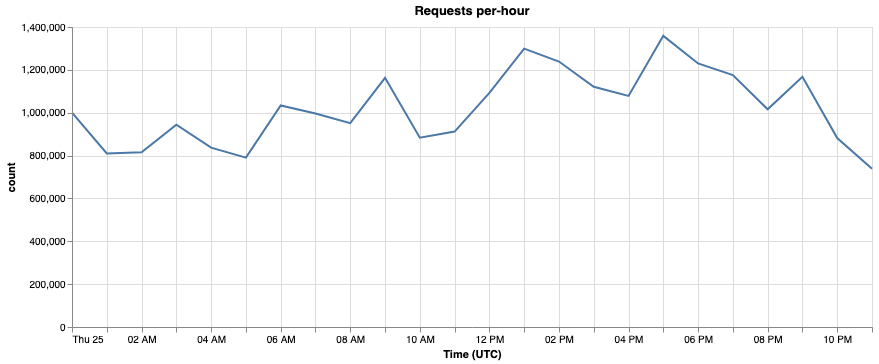

In [11]:
import altair
altair.renderers.enable('notebook')

chart = altair.Chart(df_2018.reset_index()).mark_line().encode(
    altair.X('time:T', title='Time (UTC)'),
    altair.Y('count:Q')
)

chart = chart.properties(
    title='Requests per-hour',
    width=800
)

chart